In [82]:
# notebook to load in embedding lists, and see if colbert embeddings are more similar within each other or 
# not vs random
from setretrieval.utils.utils import pickload, pickdump
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity

from itertools import combinations
import random
from matplotlib.patches import Patch
from tqdm import tqdm
from datasets import Dataset
from pylate.scores import colbert_scores
import torch
from pylate.utils.tensor import convert_to_tensor
from collections import Counter

In [31]:
def colbert_scores(
    queries_embeddings: list | np.ndarray | torch.Tensor,
    documents_embeddings: list | np.ndarray | torch.Tensor,
    queries_mask: torch.Tensor = None,
    documents_mask: torch.Tensor = None,
) -> torch.Tensor:

    queries_embeddings = convert_to_tensor(queries_embeddings)
    documents_embeddings = convert_to_tensor(documents_embeddings)

    scores = torch.einsum(
        "ash,bth->abst",
        queries_embeddings,
        documents_embeddings,
    )

    if queries_mask is not None:
        queries_mask = convert_to_tensor(queries_mask)
        scores = scores * queries_mask.unsqueeze(1).unsqueeze(3)

    if documents_mask is not None:
        documents_mask = convert_to_tensor(documents_mask)
        scores = scores * documents_mask.unsqueeze(0).unsqueeze(2)
    scores = scores.max(axis=-1).values # .sum(axis=-1), HACK keep token-level values
    return scores

In [7]:
nounqueries = pickload("../propercache/cache/embdiversity/128nounmodtest/query.pkl")
nountraindocs = pickload("../propercache/cache/embdiversity/128nounmodtest/document.pkl")

In [ ]:
tests100 = Dataset.load_from_disk("../propercache/data/evalsets/nountest100")
docs = Dataset.load_from_disk("../propercache/data/datastores/heldoutnouns")
trueinds = []
alldocs = [d['text'] for d in docs]
for t in tests100:
    tmp = []
    for i, c in enumerate(t['pos_chunks']):
        tmp.append(alldocs.index(c))
    trueinds.append(tmp)

In [84]:
flattened_trueinds = [docs[item]['text'] for sublist in trueinds for item in sublist]
trueind_counts = Counter(flattened_trueinds)
sorted_trueind_counts = sorted(trueind_counts.items(), key=lambda x: x[1], reverse=True)
print(sorted_trueind_counts)


[('hit', 432), ('delivery', 327), ('pass', 297), ('catching', 290), ('slip', 278), ('retreat', 277), ('return', 265), ('hook', 247), ('pratfall', 227), ('shot', 222), ('substance', 220), ('conquest', 220), ('fall', 220), ('lick', 216), ('snap', 216), ('contact', 214), ('reception', 214), ('salvage', 213), ('smacker', 212), ('redemption', 211), ('coming', 211), ('arrival', 210), ('record', 210), ('playing', 210), ('reclamation', 209), ('assumption', 209), ('strike', 209), ('recapture', 207), ('going', 206), ('smack', 206), ('performance', 204), ('relation', 203), ('belching', 203), ('credit', 202), ('remission', 202), ('thing', 201), ('launching', 200), ('abandonment', 200), ('kiss', 198), ('motivation', 196), ('bowling', 196), ('incursion', 195), ('catch', 195), ('jab', 194), ('discard', 194), ('consummation', 194), ('goal-kick', 194), ('emergence', 192), ('seizure', 192), ('nutrient', 191), ('salvation', 190), ('smash', 189), ('lapse', 188), ('header', 188), ('heave', 188), ('bootlegg

In [61]:
comp_cscos = [colbert_scores(nounqueries, [nountraindocs[i]]) for i in tqdm(range(len(nountraindocs)))]

100%|██████████| 1000/1000 [00:14<00:00, 71.02it/s]


In [ ]:
msdocs = np.array([comp_cscos[i].sum(axis=-1).squeeze(1) for i in range(len(comp_cscos))])
qdocscos = msdocs.transpose()

Text(0.5, 0, 'Total scores for different documents (one query)')

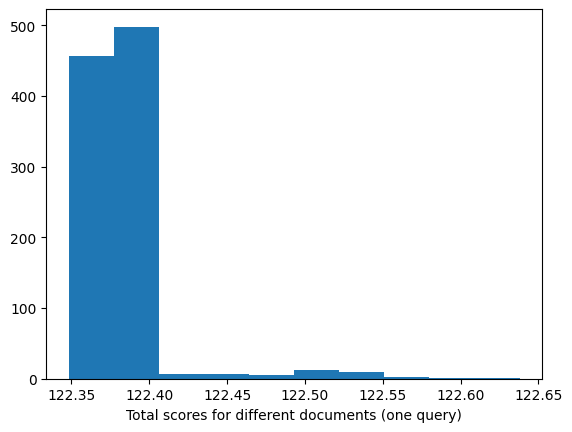

In [78]:
plt.hist(qdocscos[3])
plt.xlabel("Total scores for different documents (one query)")

Text(0, 0.5, 'Count')

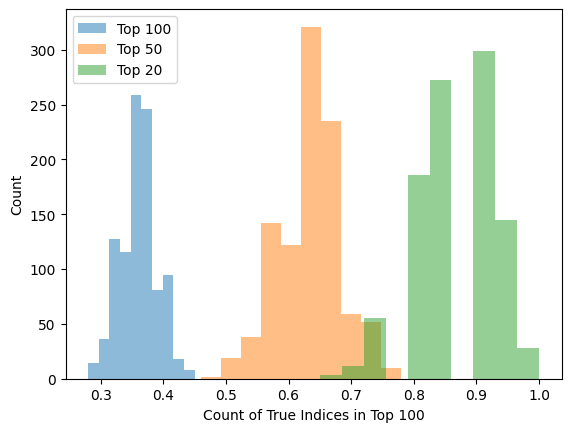

In [ ]:
# sort each row in qdocscos, get top 100 indices
def tpcnt(nval): 
    topinds = np.argsort(qdocscos, axis=-1)[:, -nval:]
    # for each trueind, get count that are in top 100 
    topinds_count = [np.sum(np.isin(topinds[i], trueinds[i])) / nval for i in range(len(trueinds))]
    return topinds_count

# plot histogram
plt.hist(tpcnt(100), alpha=0.5, label="Top 100")
plt.hist(tpcnt(50), alpha=0.5, label="Top 50")
plt.hist(tpcnt(20), alpha=0.5, label="Top 20")
plt.legend()
plt.xlabel("Count of True Indices in Top 100")
plt.ylabel("Count")

In [86]:
# for each document (by index), calculate 
top100s = np.argsort(qdocscos, axis=-1)[:, -100:]

Text(0, 0.5, 'Count')

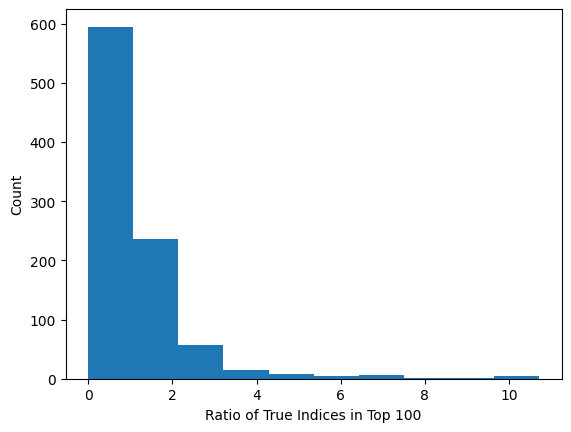

In [ ]:
# flatten and get counter
top100s_flat = [docs[i]['text'] for i in top100s.flatten()]
top100s_counts = Counter(top100s_flat)
ratiodict = {}
for k in trueind_counts:
    if k in top100s_counts:
        ratiodict[k] = top100s_counts[k] / trueind_counts[k]
    else:
        ratiodict[k] = 0

# plot histogram
plt.hist(list(ratiodict.values()))
plt.xlabel("Ratio of True Indices in Top 100")
plt.ylabel("Count")

In [ ]:
# for each trueind, get count that are in top 100 

array([229, 230, 311, 206, 211, 899, 171, 521,  85, 205, 182, 458,  71,
       923, 673, 365, 455, 760, 680, 897, 686, 902, 236, 231, 503, 198,
       324, 164, 763, 477, 112, 805, 444, 858, 879, 357, 133, 796,  38,
       421, 332, 347, 162, 553, 478, 520, 674, 267, 554, 462, 100, 277,
       974, 648, 985, 808, 179, 522, 394, 132, 210, 813, 725, 443, 461,
       459, 804, 362, 898, 997, 909, 842, 416, 753, 514, 916, 411, 815,
       286, 388, 940, 515,  99, 127, 448, 408, 679,  11, 984, 406, 911,
       509, 749, 829, 265, 967, 807, 268, 269, 358, 914, 968, 204, 747,
       497, 336, 620, 451, 702, 665, 965, 150, 193, 405, 241, 696, 319,
       106, 823, 126, 854, 572, 135, 512,  76, 342, 502, 734, 412, 931,
       831, 373, 479, 602,  70, 234, 625, 250, 929, 697, 495, 506, 239,
       933, 518, 621, 742, 260, 692, 402, 937, 687, 449, 710, 315, 839,
       185, 186, 872, 826, 994, 352, 392, 664, 233, 614, 595, 802,  14,
       939, 571, 986, 398, 368,  80, 700, 499, 498, 780, 173, 55

In [69]:
msdocs.shape

(1000, 1000)

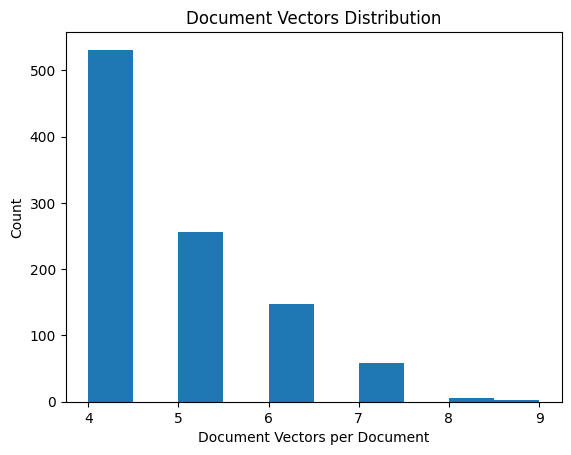

In [27]:
# document vector counts plotted
plt.hist([len(doc) for doc in nountraindocs])
plt.xlabel("Document Vectors per Document")
plt.ylabel("Count")
plt.title("Document Vectors Distribution")
plt.show()


In [8]:
len(nountraindocs)

1000

In [46]:
# query vectors
bertqueries = pickload("../propercache/cache/embdiversity/bertwikidefault/query.pkl")
colbertqueries = pickload("../propercache/cache/embdiversity/colbertwikidefault/query.pkl")

# document vectors
bertdocs = pickload("../propercache/cache/embdiversity/bertwikidefault/document.pkl")
colbertdocs = pickload("../propercache/cache/embdiversity/colbertwikidefault/document.pkl")

In [90]:
def compute_avg_pairwise_similarity(embedding_list, n=1000, do_average=False):
    """
    Compute average pairwise cosine similarity for embeddings within each list,
    then average across all lists.
    
    Args:
        embedding_list: List of lists of embeddings
        n: Number of entries to process (default 1000)
    
    Returns:
        Average pairwise similarity across all lists
    """
    
    similarities = []
    
    for embeddings in embedding_list[:n]:
        if len(embeddings) < 2:
            continue
        
        # Convert to numpy array and compute all pairwise similarities at once
        emb_matrix = np.array(embeddings)
        sim_matrix = cosine_similarity(emb_matrix)
        
        # Extract upper triangle (excluding diagonal) to get unique pairs
        triu_indices = np.triu_indices_from(sim_matrix, k=1)
        pairwise_sims = sim_matrix[triu_indices]
        
        if len(pairwise_sims) > 0:
            similarities.append(np.mean(pairwise_sims))
    
    if do_average:
        return np.mean(similarities) if similarities else 0.0
    else:
        return np.array(similarities)

def compute_random_baseline(embedding_list, n=1000, n_samples=1000, do_average=False):

    # Flatten to get all individual embeddings
    all_embs1 = list([emb for emb_list in embedding_list[:n] for emb in emb_list])
    similarities = []
    for _ in range(n_samples):
        emb1 = random.choice(all_embs1)     
        emb2 = random.choice(all_embs1)
        sim = 1 - cosine(emb1, emb2)
        similarities.append(sim)
    
    if do_average:
        return np.mean(similarities)
    else:
        return np.array(similarities)


In [92]:
apsims = compute_avg_pairwise_similarity(nounqueries, n=1000)

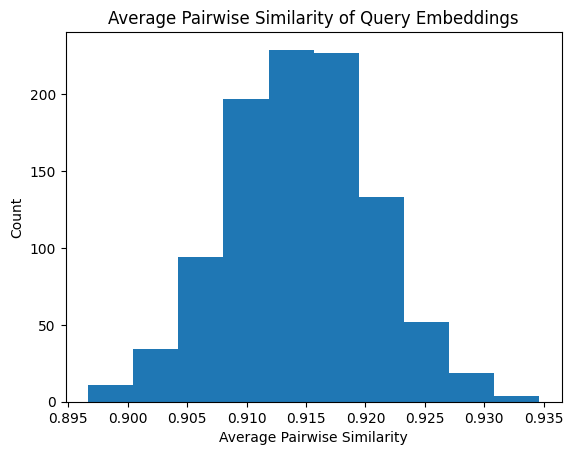

In [ ]:
plt.hist(apsims)
plt.ylabel("Count")
plt.xlabel("Average Pairwise Similarity")
plt.title("Average Pairwise Similarity of Query Embeddings")
plt.show()

In [43]:

# Compute average pairwise similarities
print("Computing average pairwise similarities...")
bert_query_sim = compute_avg_pairwise_similarity(bertqueries, n=1000)
colbert_query_sim = compute_avg_pairwise_similarity(colbertqueries, n=1000)
bert_doc_sim = compute_avg_pairwise_similarity(bertdocs, n=1000)
colbert_doc_sim = compute_avg_pairwise_similarity(colbertdocs, n=1000)

print(f"BERT Query avg pairwise similarity: {bert_query_sim:.4f}")
print(f"ColBERT Query avg pairwise similarity: {colbert_query_sim:.4f}")
print(f"BERT Doc avg pairwise similarity: {bert_doc_sim:.4f}")
print(f"ColBERT Doc avg pairwise similarity: {colbert_doc_sim:.4f}")

# Compute random baselines
print("\nComputing random baselines...")
bert_query_random = compute_random_baseline(bertqueries, n=1000)
colbert_query_random = compute_random_baseline(colbertqueries, n=1000)
bert_doc_random = compute_random_baseline(bertdocs, n=1000)
colbert_doc_random = compute_random_baseline(colbertdocs, n=1000)

print(f"BERT Query (random): {bert_query_random:.4f}")
print(f"ColBERT Query (random): {colbert_query_random:.4f}")
print(f"BERT Doc (random): {bert_doc_random:.4f}")
print(f"ColBERT Doc (random): {colbert_doc_random:.4f}")

# Create histogram
fig, ax = plt.subplots(figsize=(12, 6))

categories = ['BERT Query', 'ColBERT Query', 'BERT Doc', 'ColBERT Doc']
values = [bert_query_sim, colbert_query_sim, bert_doc_sim, colbert_doc_sim]
baselines = [bert_query_random, colbert_query_random, bert_doc_random, colbert_doc_random]
baseline_labels = ['BERT Query\n(random)', 'ColBERT Query\n(random)', 
                   'BERT Doc\n(random)', 'ColBERT Doc\n(random)']

colors = ['#3498db', '#e74c3c', '#3498db', '#e74c3c']
baseline_colors = ['#2980b9', '#c0392b', '#2980b9', '#c0392b']

bars = ax.bar(categories, values, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for bar, val in zip(bars, values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.4f}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# Add vertical dashed lines for random baselines
for i, (baseline, label, color) in enumerate(zip(baselines, baseline_labels, baseline_colors)):
    x_pos = i
    ax.axhline(y=baseline, xmin=(x_pos-0.4)/len(categories), xmax=(x_pos+0.4)/len(categories),
               color=color, linestyle='--', linewidth=2, alpha=0.8, label=label)
    # Add baseline value label
    ax.text(x_pos, baseline, f'{baseline:.4f}', 
            ha='center', va='bottom', fontsize=9, 
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8, edgecolor=color))

ax.set_ylabel('Average Cosine Similarity', fontsize=12, fontweight='bold')
ax.set_title('Average Pairwise Similarities: Within-List vs Random Baselines', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_ylim(0, max(values + baselines) * 1.15)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add legend
ax.legend(loc='upper right', fontsize=9, framealpha=0.9)

plt.tight_layout()
plt.show()

Computing average pairwise similarities...


TypeError: unsupported format string passed to numpy.ndarray.__format__

Computing pairwise similarity distributions...
BERT Query: 533 pairs, mean=0.4662
ColBERT Query: 533 pairs, mean=0.3785
BERT Doc: 1000 pairs, mean=0.3586
ColBERT Doc: 1000 pairs, mean=0.4192

Computing random baseline distributions...
BERT Query (random): mean=0.0474
ColBERT Query (random): mean=0.0985
BERT Doc (random): mean=0.2715
ColBERT Doc (random): mean=0.1540


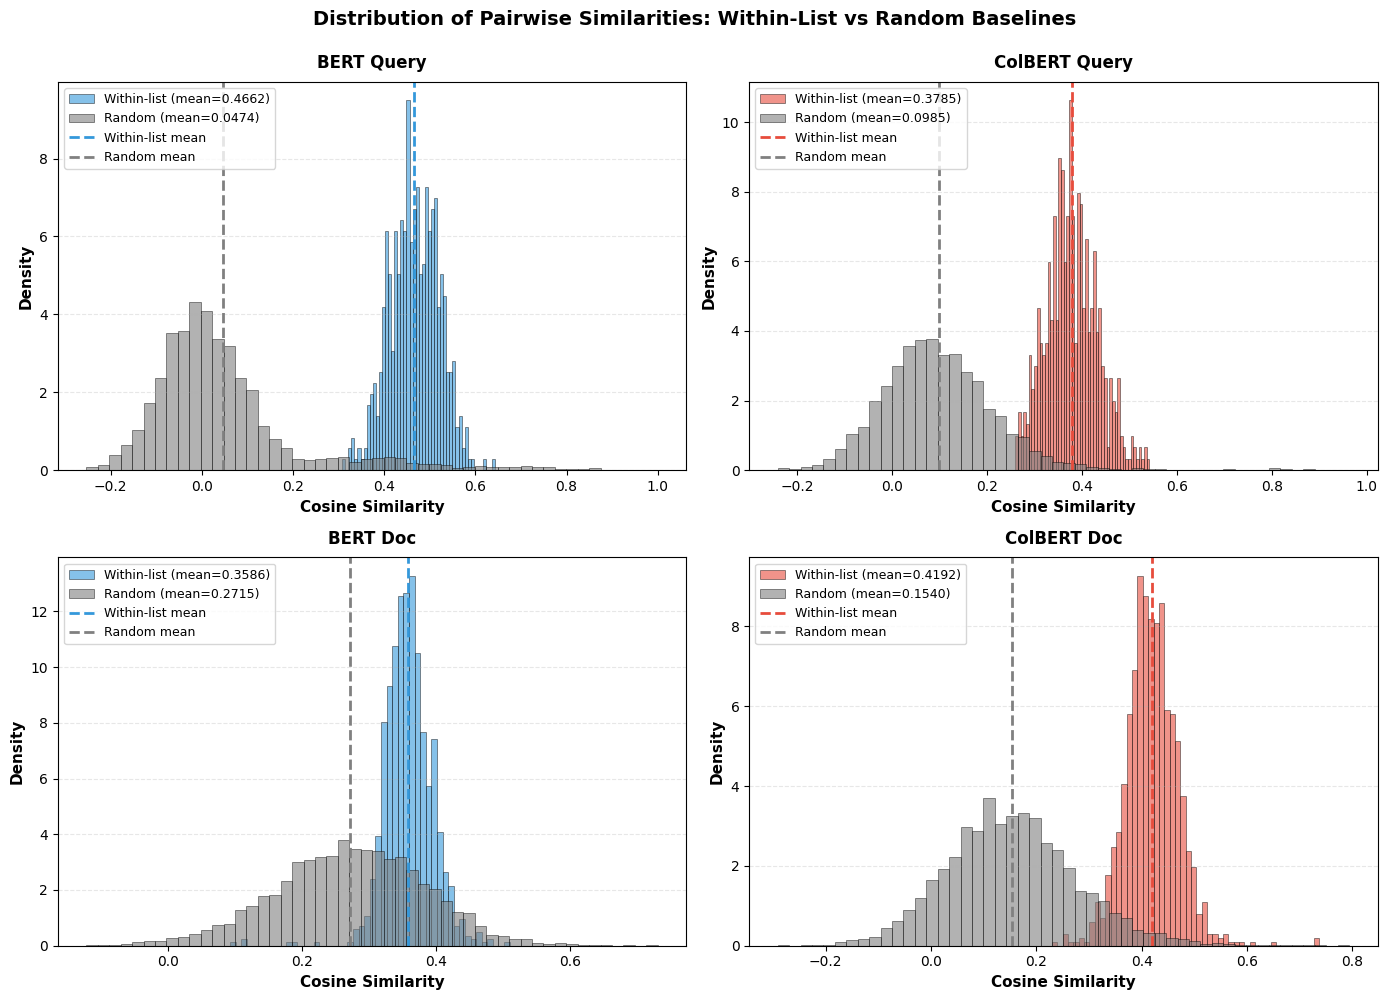

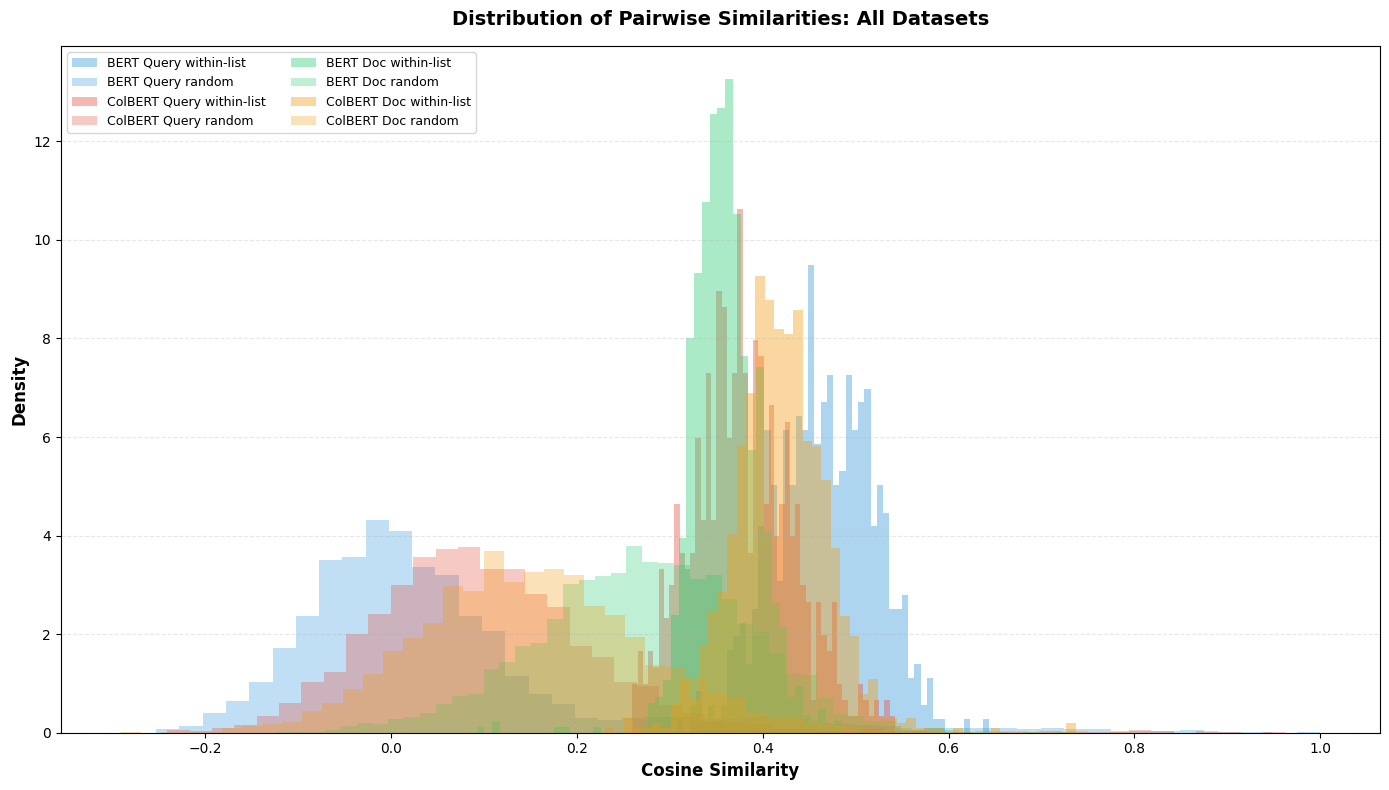

In [54]:
import random 
# Compute pairwise similarities (full distributions)
print("Computing pairwise similarity distributions...")
bert_query_sims = compute_avg_pairwise_similarity(bertqueries, n=1000)
colbert_query_sims = compute_avg_pairwise_similarity(colbertqueries, n=1000)
bert_doc_sims = compute_avg_pairwise_similarity(bertdocs, n=1000)
colbert_doc_sims = compute_avg_pairwise_similarity(colbertdocs, n=1000)

print(f"BERT Query: {len(bert_query_sims)} pairs, mean={bert_query_sims.mean():.4f}")
print(f"ColBERT Query: {len(colbert_query_sims)} pairs, mean={colbert_query_sims.mean():.4f}")
print(f"BERT Doc: {len(bert_doc_sims)} pairs, mean={bert_doc_sims.mean():.4f}")
print(f"ColBERT Doc: {len(colbert_doc_sims)} pairs, mean={colbert_doc_sims.mean():.4f}")

# Compute random baselines
print("\nComputing random baseline distributions...")
bert_query_random = compute_random_baseline(bertqueries, n=1000, n_samples=5000)
colbert_query_random = compute_random_baseline(colbertqueries, n=1000, n_samples=5000)
bert_doc_random = compute_random_baseline(bertdocs, n=1000, n_samples=5000)
colbert_doc_random = compute_random_baseline(colbertdocs, n=1000, n_samples=5000)

print(f"BERT Query (random): mean={bert_query_random.mean():.4f}")
print(f"ColBERT Query (random): mean={colbert_query_random.mean():.4f}")
print(f"BERT Doc (random): mean={bert_doc_random.mean():.4f}")
print(f"ColBERT Doc (random): mean={colbert_doc_random.mean():.4f}")

# Create figure with 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

datasets = [
    (bert_query_sims, bert_query_random, 'BERT Query', '#3498db'),
    (colbert_query_sims, colbert_query_random, 'ColBERT Query', '#e74c3c'),
    (bert_doc_sims, bert_doc_random, 'BERT Doc', '#3498db'),
    (colbert_doc_sims, colbert_doc_random, 'ColBERT Doc', '#e74c3c')
]

for ax, (pairwise, random, title, color) in zip(axes, datasets):
    # Plot histograms
    ax.hist(pairwise, bins=50, alpha=0.6, color=color, 
            label=f'Within-list (mean={pairwise.mean():.4f})', 
            density=True, edgecolor='black', linewidth=0.5)
    ax.hist(random, bins=50, alpha=0.6, color='gray', 
            label=f'Random (mean={random.mean():.4f})', 
            density=True, edgecolor='black', linewidth=0.5)
    
    # Add vertical lines for means
    ax.axvline(pairwise.mean(), color=color, linestyle='--', linewidth=2, 
               label=f'Within-list mean')
    ax.axvline(random.mean(), color='gray', linestyle='--', linewidth=2, 
               label=f'Random mean')
    
    ax.set_xlabel('Cosine Similarity', fontsize=11, fontweight='bold')
    ax.set_ylabel('Density', fontsize=11, fontweight='bold')
    ax.set_title(title, fontsize=12, fontweight='bold', pad=10)
    ax.legend(loc='upper left', fontsize=9)
    ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.suptitle('Distribution of Pairwise Similarities: Within-List vs Random Baselines', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# Create overlaid version (all on one plot)
fig, ax = plt.subplots(figsize=(14, 8))

colors_list = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']
labels = ['BERT Query', 'ColBERT Query', 'BERT Doc', 'ColBERT Doc']
all_pairwise = [bert_query_sims, colbert_query_sims, bert_doc_sims, colbert_doc_sims]
all_random = [bert_query_random, colbert_query_random, bert_doc_random, colbert_doc_random]

for pairwise, random, label, color in zip(all_pairwise, all_random, labels, colors_list):
    ax.hist(pairwise, bins=50, alpha=0.4, color=color, 
            label=f'{label} within-list', density=True, linewidth=2)
    ax.hist(random, bins=50, alpha=0.3, color=color, 
            label=f'{label} random', density=True,  
            linewidth=2, linestyle='--')

ax.set_xlabel('Cosine Similarity', fontsize=12, fontweight='bold')
ax.set_ylabel('Density', fontsize=12, fontweight='bold')
ax.set_title('Distribution of Pairwise Similarities: All Datasets', 
             fontsize=14, fontweight='bold', pad=15)
ax.legend(loc='upper left', fontsize=9, ncol=2)
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

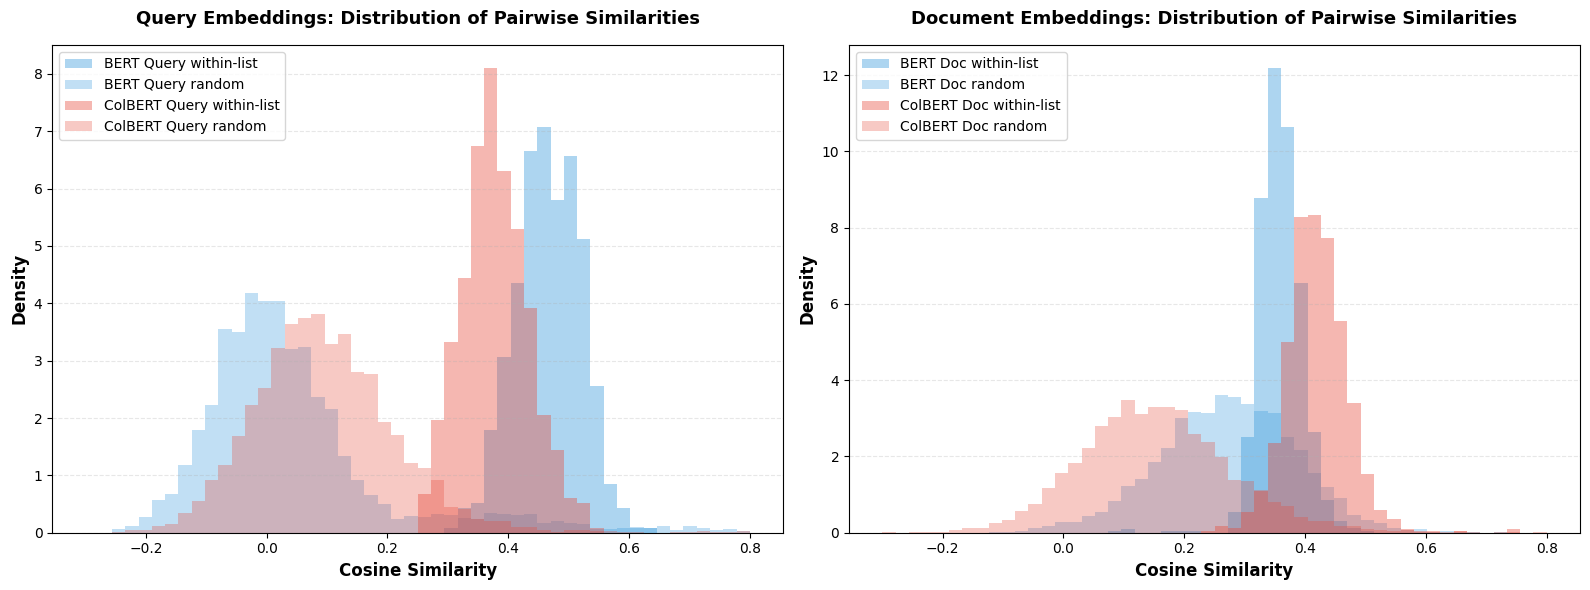

In [57]:

# Create separate plots for Query vs Document
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Query plot
query_colors = ['#3498db', '#e74c3c']
query_labels = ['BERT Query', 'ColBERT Query']
query_pairwise = [bert_query_sims, colbert_query_sims]
query_random = [bert_query_random, colbert_query_random]

for pairwise, random, label, color in zip(query_pairwise, query_random, query_labels, query_colors):
    ax1.hist(pairwise, bins=50, alpha=0.4, color=color, 
            label=f'{label} within-list', density=True, linewidth=2, range=(-0.3, 0.8))
    ax1.hist(random, bins=50, alpha=0.3, color=color, 
            label=f'{label} random', density=True,  
            linewidth=2, linestyle='--', range=(-0.3, 0.8))

ax1.set_xlabel('Cosine Similarity', fontsize=12, fontweight='bold')
ax1.set_ylabel('Density', fontsize=12, fontweight='bold')
ax1.set_title('Query Embeddings: Distribution of Pairwise Similarities', 
             fontsize=13, fontweight='bold', pad=15)
ax1.legend(loc='upper left', fontsize=10)
ax1.grid(axis='y', alpha=0.3, linestyle='--')

# Document plot
doc_colors = ['#3498db', '#e74c3c']
doc_labels = ['BERT Doc', 'ColBERT Doc']
doc_pairwise = [bert_doc_sims, colbert_doc_sims]
doc_random = [bert_doc_random, colbert_doc_random]

for pairwise, random, label, color in zip(doc_pairwise, doc_random, doc_labels, doc_colors):
    ax2.hist(pairwise, bins=50, alpha=0.4, color=color, 
            label=f'{label} within-list', density=True, linewidth=2, range=(-0.3, 0.8))
    ax2.hist(random, bins=50, alpha=0.3, color=color, 
            label=f'{label} random', density=True,  
            linewidth=2, linestyle='--', range=(-0.3, 0.8))

ax2.set_xlabel('Cosine Similarity', fontsize=12, fontweight='bold')
ax2.set_ylabel('Density', fontsize=12, fontweight='bold')
ax2.set_title('Document Embeddings: Distribution of Pairwise Similarities', 
             fontsize=13, fontweight='bold', pad=15)
ax2.legend(loc='upper left', fontsize=10)
ax2.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

In [ ]:
# 